Import Library ges

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import LabelEncoder

Dataset ada di link url

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# # Download the dataset from the provided Google Drive link
# !pip install gdown
# import gdown

# # dataset ganteng
# url = 'https://drive.google.com/drive/folders/11iCOpkGKEktSeVWP4ypRwFq_wNIBRZEq?usp=sharing'
# gdown.download_folder(url, output='/content/dataset', quiet=False)

# Set the path to the dataset
dataset_path = '/content/drive/MyDrive/dataset'

# Initialize data and labels lists
data = []
labels = []

# Define the image size (e.g., 224x224 for VGG16)
IMG_SIZE = (224, 224)

# Load images and labels
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            img = img_to_array(img)
            data.append(img)
            labels.append(category)

# Convert data and labels to numpy arrays
data = np.array(data, dtype='float32')
labels = np.array(labels)



Mounted at /content/drive


In [10]:
# Load the VGG16 network, with weights pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using the pre-trained network
features = base_model.predict(data)
features = features.reshape(features.shape[0], -1)

# Encode labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split the dataset and apply different scalers
features_labels_splits = []
scalers = [Normalizer(), MinMaxScaler(), StandardScaler(), RobustScaler()]
scaler_names = ['Normalizer', 'MinMaxScaler', 'StandardScaler', 'RobustScaler']
test_sizes = [0.3, 0.2]

# Splitting and scaling data
for test_size in test_sizes:
    for scaler, scaler_name in zip(scalers, scaler_names):
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=42)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        features_labels_splits.append((X_train, X_test, y_train, y_test, scaler_name, test_size))


55/55 [==============================] - 1130s 20s/step


In [11]:
# Define a function to train and evaluate SVM with different kernels
def evaluate_svm_kernels(X_train, X_test, y_train, y_test):
    kernels = ['rbf', 'linear', 'poly']
    results = {}

    for kernel in kernels:
        if kernel == 'poly':
            svm = SVC(kernel=kernel, degree=3)
        else:
            svm = SVC(kernel=kernel)

        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)

        results[kernel] = {
            "Accuracy": accuracy_score(y_test, y_pred),
            "Classification Report": classification_report(y_test, y_pred),
            "Confusion Matrix": confusion_matrix(y_test, y_pred)
        }

    return results

In [12]:
# Applying the function to each split dataset
svm_results = []
for X_train, X_test, y_train, y_test, scaler_name, test_size in features_labels_splits:
    results = evaluate_svm_kernels(X_train, X_test, y_train, y_test)
    svm_results.append((results, scaler_name, test_size))

# Print results and store accuracies for plotting
all_accuracies = []

for i, (result, scaler_name, test_size) in enumerate(svm_results):
    split_detail = f"Scaler: {scaler_name}, Test Size: {test_size}"
    print(f"Results for {split_detail}:\n")
    for kernel, metrics in result.items():
        print(f"{kernel.capitalize()} Kernel")
        print("Accuracy:", metrics["Accuracy"])
        print("Classification Report:\n", metrics["Classification Report"])
        print("Confusion Matrix:\n", metrics["Confusion Matrix"])
        print("\n" + "="*50 + "\n")
        all_accuracies.append((scaler_name, test_size, kernel.capitalize(), metrics["Accuracy"]))

Results for Scaler: Normalizer, Test Size: 0.3:

Rbf Kernel
Accuracy: 0.7610789980732178
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.72       152
           1       0.77      0.78      0.77       181
           2       0.80      0.77      0.78       186

    accuracy                           0.76       519
   macro avg       0.76      0.76      0.76       519
weighted avg       0.76      0.76      0.76       519

Confusion Matrix:
 [[110  23  19]
 [ 22 141  18]
 [ 22  20 144]]


Linear Kernel
Accuracy: 0.7475915221579962
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.70      0.70       152
           1       0.76      0.75      0.75       181
           2       0.79      0.78      0.78       186

    accuracy                           0.75       519
   macro avg       0.74      0.74      0.74       519
weighted avg       0.75      0.75      0.75   

In [13]:
# Organize accuracies by scaler and kernel for plotting
scaler_testsize_combinations = [(scaler_name, test_size) for scaler_name in scaler_names for test_size in test_sizes]
kernel_names = ['RBF', 'Linear', 'Polynomial']

# Initialize dictionary to hold accuracies
accuracies_by_scaler = {combination: {kernel: 0 for kernel in kernel_names} for combination in scaler_testsize_combinations}

for scaler_name, test_size, kernel, accuracy in all_accuracies:
    accuracies_by_scaler[(scaler_name, test_size)][kernel] = accuracy

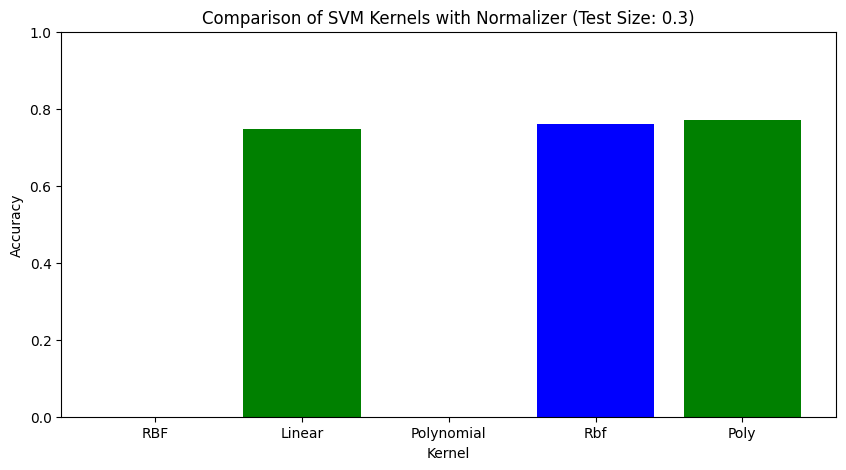

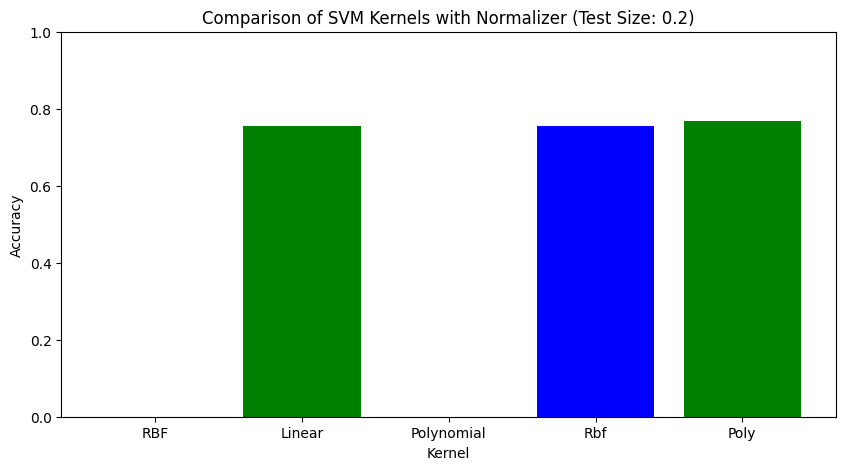

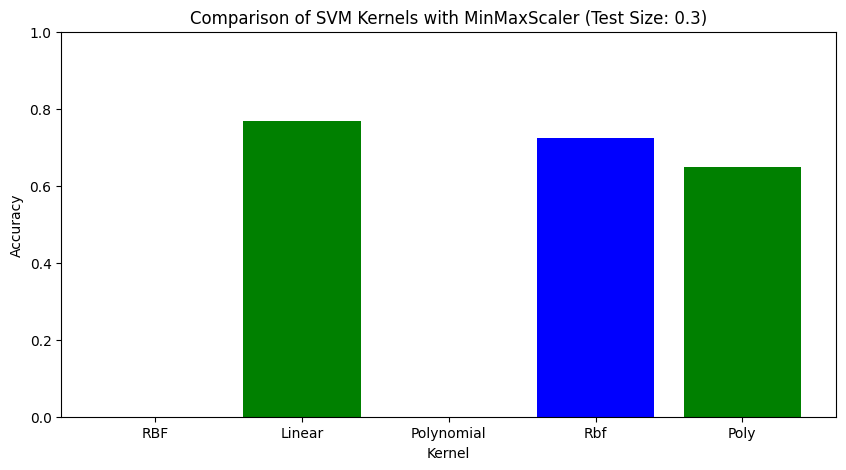

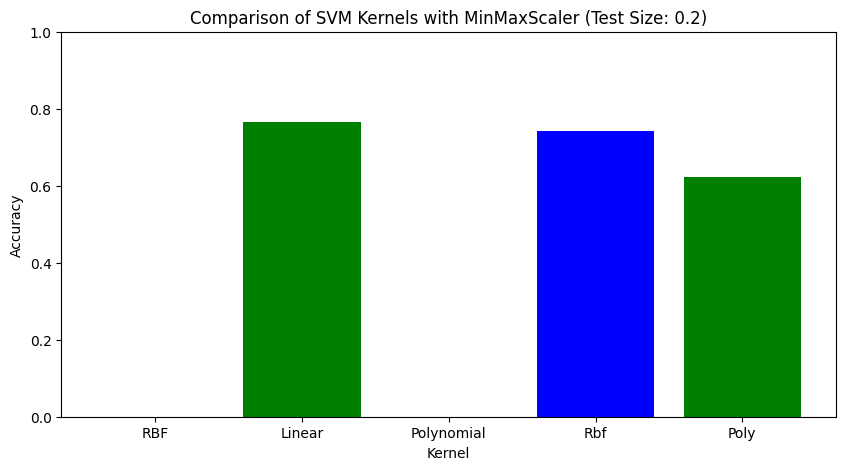

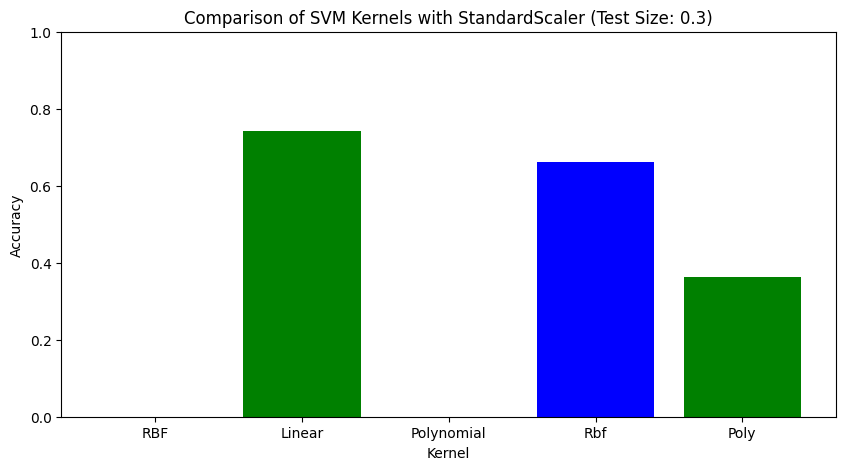

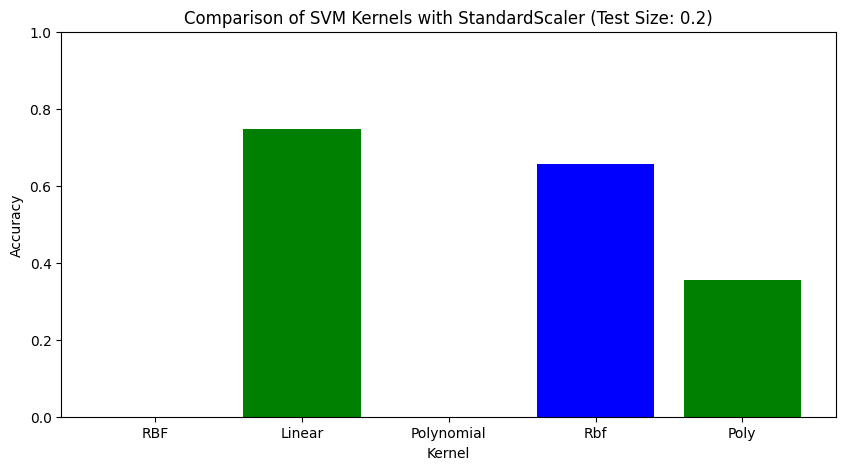

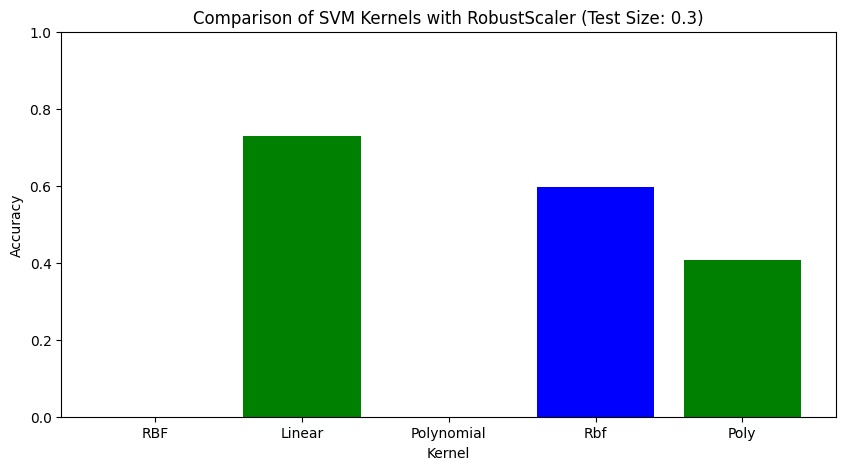

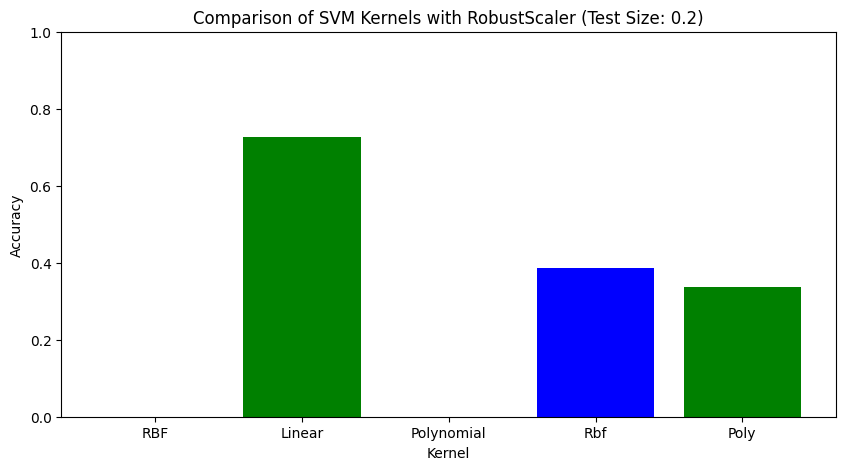

In [14]:
# Plotting the accuracies for each scaler and test size combination
for (scaler_name, test_size), kernel_accuracies in accuracies_by_scaler.items():
    plt.figure(figsize=(10, 5))
    plt.bar(kernel_accuracies.keys(), kernel_accuracies.values(), color=['blue', 'green', 'red'])
    plt.xlabel('Kernel')
    plt.ylabel('Accuracy')
    plt.title(f'Comparison of SVM Kernels with {scaler_name} (Test Size: {test_size})')
    plt.ylim(0, 1)  # Ensure the y-axis is consistent for better comparison
    plt.show()